In [1]:
import numpy as mp
import matplotlib.pyplot as plt
import time
import numba
import random
from load_mnist import *
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
shuffle_index = np.random.permutation(60000)
X_train, Y_train = X_train[shuffle_index],Y_train[shuffle_index]
label = []
for i in range(len(Y_train)):
    label.append(Y_train[i].argmax())
    
label = np.array(label).reshape(60000,)

label_t = []
for i in range(len(Y_test)):
    label_t.append(Y_test[i].argmax())
    
label_t = np.array(label_t).reshape(10000,)

In [2]:
class AffineComponent:
    def __init__(self,input_dim,output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = 0.01 * np.random.randn(input_dim, output_dim)
        self.bias = 0.01 * np.random.randn(1,output_dim)

    def propagate(self,input_data):
        assert input_data.shape[1] == self.input_dim
        self.input_data = input_data
        return input_data @ self.weights + self.bias

    def back_propagate(self,derivative):
        assert derivative.shape[1] == self.output_dim
        propagate_derivative = derivative @ self.weights.T
        self.__update(derivative)
        return propagate_derivative

    def __update(self,derivative):
        #the learning rate is a global value which will change while training
        #see more detain in LearningRateScheduler
        self.bias -= learning_rate * derivative.sum(axis = 0, keepdims= True )
        self.weights -= learning_rate * (self.input_data.T @ derivative)


class NolinearComponent:
    def __init__(self,dim,nolinear_type):
        self.dim = dim
        self.nolinear_type = nolinear_type

    def propagate(self,input_data):
        assert input_data.shape[1] == self.dim
        self.input_data = input_data
        if(self.nolinear_type == "relu"):
            return self.__relu(input_data)
        else:
            #program is not expected to reach here
            assert false

    def __relu(self,input_data):
        #important! must use copy or the input data will be change through index
        output_data = input_data.copy()
        output_data[output_data < 0] = 0
        return output_data
    #----------------------------
    def back_propagate(self,derivative):
        assert derivative.shape[1] == self.dim
        if(self.nolinear_type == "relu"):
            return self.__back_relu(derivative)
        else:
            #program is not expected to reach here
            assert false
            
    def __back_relu(self,derivative):
        derivative[self.input_data < 0] = 0
        return derivative


class SoftmaxOutputComponent:
    def __init__(self,dim):
        self.dim = dim

    def propagate(self,input_data):
        assert input_data.shape[1] == self.dim
        self.input_data = input_data
        e_x = np.exp(input_data)
        return e_x / e_x.sum(axis=1, keepdims=True)

    def back_propagate(self,probs,label):
        assert probs.shape[0] == label.shape[0]
        batch_size = probs.shape[0]
        delta = probs
        delta[range(batch_size),batch_label] -= 1
        return delta / batch_size

In [17]:
dnn1_affine = AffineComponent(784,10)
output = SoftmaxOutputComponent(10)

def network_propagate(input_data):
    activate = dnn1_affine.propagate(input_data)
    return output.propagate(activate)

def network_backpropagate(probs,batch_label):
    derivative = output.back_propagate(probs,batch_label)
    derivative = dnn1_affine.back_propagate(derivative)

def caculate_loss(probs,batch_label):
    batch_size = probs.shape[0]
    loss_list = -np.log(probs[range(batch_size), batch_label])
    average_loss = loss_list.mean(axis=0)
    return average_loss

In [4]:
def score(batch_data, batch_label):
    probs = network_propagate(batch_data)
    prediction = probs.argmax(axis = 1).reshape(batch_label.shape[0],1)
    correct_num = np.sum(batch_label == prediction.T)
    loss = caculate_loss(probs, batch_label)
    
    return float(correct_num) / batch_label.shape[0], loss

In [18]:
score_train = []
loss_train = []
score_test = []
loss_test = []

batch_size = 1000
epochs_num = 40
batches_X = np.array([X_train[i:i+batch_size] for i in range(0, X_train.shape[0], batch_size)])
batches_Y = np.array([label[i:i+batch_size] for i in range(0, Y_train.shape[0], batch_size)])
batches_num = batches_X.shape[0]
for epoch in range(epochs_num):
    for i in range(batches_num):
        learning_rate = 1
        batch_data, batch_label = batches_X[i], batches_Y[i]
        probs = network_propagate(batch_data)
        network_backpropagate(probs, batch_label)
        result_train = score(X_train, label)
        score_train.append(result_train[0])
        loss_train.append(result_train[1])    
        result_test = score(X_test, label_t)
        score_test.append(result_test[0])
        loss_test.append(result_test[1])
        print("(",len(score_train),")","scr_trn:", format(result_train[0],'.4f'), "ls_trn:", format(result_train[1],'.4f'), "scr_tst:", format(result_test[0],'.4f'), "ls_tst:", format(result_test[1],'.4f'),)

( 1 ) scr_trn: 0.5068 ls_trn: 1.5707 scr_tst: 0.5024 ls_tst: 1.5640
( 2 ) scr_trn: 0.4761 ls_trn: 1.5627 scr_tst: 0.4770 ls_tst: 1.5406
( 3 ) scr_trn: 0.5213 ls_trn: 1.8152 scr_tst: 0.5187 ls_tst: 1.8368
( 4 ) scr_trn: 0.4433 ls_trn: 1.8458 scr_tst: 0.4430 ls_tst: 1.8325
( 5 ) scr_trn: 0.7031 ls_trn: 2.0569 scr_tst: 0.7103 ls_tst: 2.0632
( 6 ) scr_trn: 0.6456 ls_trn: 1.6102 scr_tst: 0.6583 ls_tst: 1.6146
( 7 ) scr_trn: 0.6292 ls_trn: 1.1868 scr_tst: 0.6355 ls_tst: 1.1791
( 8 ) scr_trn: 0.6434 ls_trn: 1.2908 scr_tst: 0.6458 ls_tst: 1.2897
( 9 ) scr_trn: 0.7094 ls_trn: 0.8766 scr_tst: 0.7176 ls_tst: 0.8470
( 10 ) scr_trn: 0.7268 ls_trn: 0.9839 scr_tst: 0.7296 ls_tst: 0.9879
( 11 ) scr_trn: 0.7531 ls_trn: 0.7459 scr_tst: 0.7615 ls_tst: 0.7255
( 12 ) scr_trn: 0.7536 ls_trn: 0.7116 scr_tst: 0.7600 ls_tst: 0.6896
( 13 ) scr_trn: 0.7600 ls_trn: 0.7272 scr_tst: 0.7626 ls_tst: 0.7115
( 14 ) scr_trn: 0.7418 ls_trn: 0.7328 scr_tst: 0.7495 ls_tst: 0.7116
( 15 ) scr_trn: 0.7598 ls_trn: 0.7850 scr_t

( 121 ) scr_trn: 0.9056 ls_trn: 0.3374 scr_tst: 0.9087 ls_tst: 0.3228
( 122 ) scr_trn: 0.9061 ls_trn: 0.3365 scr_tst: 0.9103 ls_tst: 0.3207
( 123 ) scr_trn: 0.9071 ls_trn: 0.3368 scr_tst: 0.9115 ls_tst: 0.3223
( 124 ) scr_trn: 0.9060 ls_trn: 0.3359 scr_tst: 0.9104 ls_tst: 0.3207
( 125 ) scr_trn: 0.9076 ls_trn: 0.3354 scr_tst: 0.9117 ls_tst: 0.3221
( 126 ) scr_trn: 0.9061 ls_trn: 0.3355 scr_tst: 0.9111 ls_tst: 0.3203
( 127 ) scr_trn: 0.9031 ls_trn: 0.3398 scr_tst: 0.9094 ls_tst: 0.3258
( 128 ) scr_trn: 0.9064 ls_trn: 0.3386 scr_tst: 0.9099 ls_tst: 0.3265
( 129 ) scr_trn: 0.9054 ls_trn: 0.3349 scr_tst: 0.9114 ls_tst: 0.3209
( 130 ) scr_trn: 0.9068 ls_trn: 0.3349 scr_tst: 0.9119 ls_tst: 0.3214
( 131 ) scr_trn: 0.9059 ls_trn: 0.3350 scr_tst: 0.9104 ls_tst: 0.3222
( 132 ) scr_trn: 0.9073 ls_trn: 0.3315 scr_tst: 0.9119 ls_tst: 0.3172
( 133 ) scr_trn: 0.9044 ls_trn: 0.3380 scr_tst: 0.9099 ls_tst: 0.3237
( 134 ) scr_trn: 0.9073 ls_trn: 0.3336 scr_tst: 0.9096 ls_tst: 0.3206
( 135 ) scr_trn: 0.9

( 239 ) scr_trn: 0.9132 ls_trn: 0.3090 scr_tst: 0.9162 ls_tst: 0.2992
( 240 ) scr_trn: 0.9126 ls_trn: 0.3093 scr_tst: 0.9163 ls_tst: 0.2983
( 241 ) scr_trn: 0.9140 ls_trn: 0.3083 scr_tst: 0.9147 ls_tst: 0.2987
( 242 ) scr_trn: 0.9141 ls_trn: 0.3081 scr_tst: 0.9167 ls_tst: 0.2975
( 243 ) scr_trn: 0.9141 ls_trn: 0.3088 scr_tst: 0.9176 ls_tst: 0.2991
( 244 ) scr_trn: 0.9148 ls_trn: 0.3074 scr_tst: 0.9174 ls_tst: 0.2971
( 245 ) scr_trn: 0.9152 ls_trn: 0.3072 scr_tst: 0.9172 ls_tst: 0.2985
( 246 ) scr_trn: 0.9144 ls_trn: 0.3079 scr_tst: 0.9155 ls_tst: 0.2980
( 247 ) scr_trn: 0.9114 ls_trn: 0.3118 scr_tst: 0.9156 ls_tst: 0.3026
( 248 ) scr_trn: 0.9140 ls_trn: 0.3094 scr_tst: 0.9168 ls_tst: 0.3021
( 249 ) scr_trn: 0.9140 ls_trn: 0.3071 scr_tst: 0.9167 ls_tst: 0.2983
( 250 ) scr_trn: 0.9138 ls_trn: 0.3076 scr_tst: 0.9170 ls_tst: 0.2987
( 251 ) scr_trn: 0.9141 ls_trn: 0.3083 scr_tst: 0.9167 ls_tst: 0.3001
( 252 ) scr_trn: 0.9152 ls_trn: 0.3053 scr_tst: 0.9172 ls_tst: 0.2957
( 253 ) scr_trn: 0.9

( 357 ) scr_trn: 0.9178 ls_trn: 0.2946 scr_tst: 0.9197 ls_tst: 0.2869
( 358 ) scr_trn: 0.9178 ls_trn: 0.2950 scr_tst: 0.9189 ls_tst: 0.2890
( 359 ) scr_trn: 0.9170 ls_trn: 0.2958 scr_tst: 0.9179 ls_tst: 0.2894
( 360 ) scr_trn: 0.9168 ls_trn: 0.2959 scr_tst: 0.9193 ls_tst: 0.2883
( 361 ) scr_trn: 0.9178 ls_trn: 0.2947 scr_tst: 0.9186 ls_tst: 0.2886
( 362 ) scr_trn: 0.9175 ls_trn: 0.2949 scr_tst: 0.9195 ls_tst: 0.2878
( 363 ) scr_trn: 0.9179 ls_trn: 0.2956 scr_tst: 0.9195 ls_tst: 0.2893
( 364 ) scr_trn: 0.9181 ls_trn: 0.2940 scr_tst: 0.9194 ls_tst: 0.2871
( 365 ) scr_trn: 0.9187 ls_trn: 0.2941 scr_tst: 0.9190 ls_tst: 0.2885
( 366 ) scr_trn: 0.9181 ls_trn: 0.2950 scr_tst: 0.9193 ls_tst: 0.2886
( 367 ) scr_trn: 0.9151 ls_trn: 0.2984 scr_tst: 0.9184 ls_tst: 0.2926
( 368 ) scr_trn: 0.9181 ls_trn: 0.2956 scr_tst: 0.9192 ls_tst: 0.2916
( 369 ) scr_trn: 0.9181 ls_trn: 0.2941 scr_tst: 0.9195 ls_tst: 0.2889
( 370 ) scr_trn: 0.9171 ls_trn: 0.2947 scr_tst: 0.9201 ls_tst: 0.2890
( 371 ) scr_trn: 0.9

( 475 ) scr_trn: 0.9203 ls_trn: 0.2881 scr_tst: 0.9210 ls_tst: 0.2828
( 476 ) scr_trn: 0.9179 ls_trn: 0.2903 scr_tst: 0.9214 ls_tst: 0.2844
( 477 ) scr_trn: 0.9200 ls_trn: 0.2864 scr_tst: 0.9210 ls_tst: 0.2813
( 478 ) scr_trn: 0.9203 ls_trn: 0.2866 scr_tst: 0.9216 ls_tst: 0.2832
( 479 ) scr_trn: 0.9193 ls_trn: 0.2878 scr_tst: 0.9193 ls_tst: 0.2840
( 480 ) scr_trn: 0.9191 ls_trn: 0.2876 scr_tst: 0.9207 ls_tst: 0.2827
( 481 ) scr_trn: 0.9201 ls_trn: 0.2864 scr_tst: 0.9202 ls_tst: 0.2829
( 482 ) scr_trn: 0.9196 ls_trn: 0.2867 scr_tst: 0.9205 ls_tst: 0.2823
( 483 ) scr_trn: 0.9200 ls_trn: 0.2875 scr_tst: 0.9216 ls_tst: 0.2838
( 484 ) scr_trn: 0.9204 ls_trn: 0.2858 scr_tst: 0.9209 ls_tst: 0.2816
( 485 ) scr_trn: 0.9211 ls_trn: 0.2860 scr_tst: 0.9210 ls_tst: 0.2830
( 486 ) scr_trn: 0.9199 ls_trn: 0.2869 scr_tst: 0.9208 ls_tst: 0.2832
( 487 ) scr_trn: 0.9177 ls_trn: 0.2900 scr_tst: 0.9189 ls_tst: 0.2869
( 488 ) scr_trn: 0.9205 ls_trn: 0.2872 scr_tst: 0.9210 ls_tst: 0.2857
( 489 ) scr_trn: 0.9

( 593 ) scr_trn: 0.9208 ls_trn: 0.2817 scr_tst: 0.9220 ls_tst: 0.2781
( 594 ) scr_trn: 0.9205 ls_trn: 0.2828 scr_tst: 0.9209 ls_tst: 0.2798
( 595 ) scr_trn: 0.9221 ls_trn: 0.2821 scr_tst: 0.9228 ls_tst: 0.2789
( 596 ) scr_trn: 0.9197 ls_trn: 0.2840 scr_tst: 0.9223 ls_tst: 0.2803
( 597 ) scr_trn: 0.9216 ls_trn: 0.2807 scr_tst: 0.9221 ls_tst: 0.2778
( 598 ) scr_trn: 0.9222 ls_trn: 0.2807 scr_tst: 0.9211 ls_tst: 0.2794
( 599 ) scr_trn: 0.9209 ls_trn: 0.2822 scr_tst: 0.9195 ls_tst: 0.2805
( 600 ) scr_trn: 0.9206 ls_trn: 0.2818 scr_tst: 0.9208 ls_tst: 0.2791
( 601 ) scr_trn: 0.9216 ls_trn: 0.2806 scr_tst: 0.9216 ls_tst: 0.2792
( 602 ) scr_trn: 0.9215 ls_trn: 0.2810 scr_tst: 0.9215 ls_tst: 0.2787
( 603 ) scr_trn: 0.9218 ls_trn: 0.2818 scr_tst: 0.9222 ls_tst: 0.2803
( 604 ) scr_trn: 0.9219 ls_trn: 0.2801 scr_tst: 0.9216 ls_tst: 0.2781
( 605 ) scr_trn: 0.9226 ls_trn: 0.2803 scr_tst: 0.9220 ls_tst: 0.2794
( 606 ) scr_trn: 0.9215 ls_trn: 0.2813 scr_tst: 0.9219 ls_tst: 0.2798
( 607 ) scr_trn: 0.9

( 711 ) scr_trn: 0.9223 ls_trn: 0.2779 scr_tst: 0.9201 ls_tst: 0.2775
( 712 ) scr_trn: 0.9233 ls_trn: 0.2773 scr_tst: 0.9213 ls_tst: 0.2770
( 713 ) scr_trn: 0.9223 ls_trn: 0.2772 scr_tst: 0.9226 ls_tst: 0.2755
( 714 ) scr_trn: 0.9214 ls_trn: 0.2783 scr_tst: 0.9213 ls_tst: 0.2772
( 715 ) scr_trn: 0.9233 ls_trn: 0.2775 scr_tst: 0.9225 ls_tst: 0.2761
( 716 ) scr_trn: 0.9214 ls_trn: 0.2793 scr_tst: 0.9230 ls_tst: 0.2775
( 717 ) scr_trn: 0.9230 ls_trn: 0.2764 scr_tst: 0.9226 ls_tst: 0.2753
( 718 ) scr_trn: 0.9236 ls_trn: 0.2763 scr_tst: 0.9216 ls_tst: 0.2767
( 719 ) scr_trn: 0.9222 ls_trn: 0.2779 scr_tst: 0.9198 ls_tst: 0.2780
( 720 ) scr_trn: 0.9223 ls_trn: 0.2774 scr_tst: 0.9214 ls_tst: 0.2766
( 721 ) scr_trn: 0.9231 ls_trn: 0.2762 scr_tst: 0.9212 ls_tst: 0.2766
( 722 ) scr_trn: 0.9228 ls_trn: 0.2766 scr_tst: 0.9217 ls_tst: 0.2762
( 723 ) scr_trn: 0.9232 ls_trn: 0.2774 scr_tst: 0.9224 ls_tst: 0.2778
( 724 ) scr_trn: 0.9233 ls_trn: 0.2758 scr_tst: 0.9223 ls_tst: 0.2756
( 725 ) scr_trn: 0.9

( 829 ) scr_trn: 0.9229 ls_trn: 0.2764 scr_tst: 0.9225 ls_tst: 0.2769
( 830 ) scr_trn: 0.9236 ls_trn: 0.2747 scr_tst: 0.9200 ls_tst: 0.2758
( 831 ) scr_trn: 0.9232 ls_trn: 0.2744 scr_tst: 0.9206 ls_tst: 0.2756
( 832 ) scr_trn: 0.9243 ls_trn: 0.2737 scr_tst: 0.9215 ls_tst: 0.2750
( 833 ) scr_trn: 0.9236 ls_trn: 0.2736 scr_tst: 0.9230 ls_tst: 0.2735
( 834 ) scr_trn: 0.9224 ls_trn: 0.2747 scr_tst: 0.9220 ls_tst: 0.2753
( 835 ) scr_trn: 0.9244 ls_trn: 0.2739 scr_tst: 0.9232 ls_tst: 0.2741
( 836 ) scr_trn: 0.9229 ls_trn: 0.2756 scr_tst: 0.9239 ls_tst: 0.2754
( 837 ) scr_trn: 0.9240 ls_trn: 0.2730 scr_tst: 0.9237 ls_tst: 0.2734
( 838 ) scr_trn: 0.9245 ls_trn: 0.2728 scr_tst: 0.9226 ls_tst: 0.2748
( 839 ) scr_trn: 0.9233 ls_trn: 0.2746 scr_tst: 0.9197 ls_tst: 0.2762
( 840 ) scr_trn: 0.9235 ls_trn: 0.2739 scr_tst: 0.9226 ls_tst: 0.2746
( 841 ) scr_trn: 0.9241 ls_trn: 0.2727 scr_tst: 0.9216 ls_tst: 0.2747
( 842 ) scr_trn: 0.9240 ls_trn: 0.2732 scr_tst: 0.9215 ls_tst: 0.2743
( 843 ) scr_trn: 0.9

( 947 ) scr_trn: 0.9245 ls_trn: 0.2735 scr_tst: 0.9228 ls_tst: 0.2769
( 948 ) scr_trn: 0.9242 ls_trn: 0.2719 scr_tst: 0.9224 ls_tst: 0.2725
( 949 ) scr_trn: 0.9241 ls_trn: 0.2734 scr_tst: 0.9227 ls_tst: 0.2753
( 950 ) scr_trn: 0.9246 ls_trn: 0.2717 scr_tst: 0.9205 ls_tst: 0.2741
( 951 ) scr_trn: 0.9240 ls_trn: 0.2716 scr_tst: 0.9199 ls_tst: 0.2741
( 952 ) scr_trn: 0.9251 ls_trn: 0.2708 scr_tst: 0.9225 ls_tst: 0.2735
( 953 ) scr_trn: 0.9245 ls_trn: 0.2706 scr_tst: 0.9240 ls_tst: 0.2721
( 954 ) scr_trn: 0.9235 ls_trn: 0.2718 scr_tst: 0.9228 ls_tst: 0.2738
( 955 ) scr_trn: 0.9252 ls_trn: 0.2710 scr_tst: 0.9232 ls_tst: 0.2725
( 956 ) scr_trn: 0.9242 ls_trn: 0.2725 scr_tst: 0.9237 ls_tst: 0.2738
( 957 ) scr_trn: 0.9250 ls_trn: 0.2702 scr_tst: 0.9231 ls_tst: 0.2720
( 958 ) scr_trn: 0.9254 ls_trn: 0.2699 scr_tst: 0.9227 ls_tst: 0.2732
( 959 ) scr_trn: 0.9240 ls_trn: 0.2718 scr_tst: 0.9199 ls_tst: 0.2747
( 960 ) scr_trn: 0.9247 ls_trn: 0.2710 scr_tst: 0.9230 ls_tst: 0.2732
( 961 ) scr_trn: 0.9

( 1064 ) scr_trn: 0.9257 ls_trn: 0.2679 scr_tst: 0.9226 ls_tst: 0.2718
( 1065 ) scr_trn: 0.9254 ls_trn: 0.2697 scr_tst: 0.9237 ls_tst: 0.2737
( 1066 ) scr_trn: 0.9252 ls_trn: 0.2705 scr_tst: 0.9221 ls_tst: 0.2739
( 1067 ) scr_trn: 0.9252 ls_trn: 0.2710 scr_tst: 0.9232 ls_tst: 0.2757
( 1068 ) scr_trn: 0.9251 ls_trn: 0.2694 scr_tst: 0.9229 ls_tst: 0.2713
( 1069 ) scr_trn: 0.9247 ls_trn: 0.2709 scr_tst: 0.9230 ls_tst: 0.2741
( 1070 ) scr_trn: 0.9255 ls_trn: 0.2691 scr_tst: 0.9214 ls_tst: 0.2728
( 1071 ) scr_trn: 0.9247 ls_trn: 0.2692 scr_tst: 0.9192 ls_tst: 0.2730
( 1072 ) scr_trn: 0.9256 ls_trn: 0.2683 scr_tst: 0.9232 ls_tst: 0.2724
( 1073 ) scr_trn: 0.9253 ls_trn: 0.2682 scr_tst: 0.9237 ls_tst: 0.2709
( 1074 ) scr_trn: 0.9243 ls_trn: 0.2694 scr_tst: 0.9231 ls_tst: 0.2726
( 1075 ) scr_trn: 0.9258 ls_trn: 0.2685 scr_tst: 0.9234 ls_tst: 0.2713
( 1076 ) scr_trn: 0.9248 ls_trn: 0.2700 scr_tst: 0.9240 ls_tst: 0.2726
( 1077 ) scr_trn: 0.9256 ls_trn: 0.2678 scr_tst: 0.9229 ls_tst: 0.2709
( 1078

( 1180 ) scr_trn: 0.9265 ls_trn: 0.2667 scr_tst: 0.9234 ls_tst: 0.2719
( 1181 ) scr_trn: 0.9263 ls_trn: 0.2658 scr_tst: 0.9221 ls_tst: 0.2720
( 1182 ) scr_trn: 0.9264 ls_trn: 0.2658 scr_tst: 0.9227 ls_tst: 0.2705
( 1183 ) scr_trn: 0.9265 ls_trn: 0.2667 scr_tst: 0.9224 ls_tst: 0.2727
( 1184 ) scr_trn: 0.9265 ls_trn: 0.2657 scr_tst: 0.9227 ls_tst: 0.2709
( 1185 ) scr_trn: 0.9259 ls_trn: 0.2675 scr_tst: 0.9234 ls_tst: 0.2727
( 1186 ) scr_trn: 0.9257 ls_trn: 0.2684 scr_tst: 0.9220 ls_tst: 0.2729
( 1187 ) scr_trn: 0.9260 ls_trn: 0.2688 scr_tst: 0.9231 ls_tst: 0.2747
( 1188 ) scr_trn: 0.9261 ls_trn: 0.2672 scr_tst: 0.9223 ls_tst: 0.2704
( 1189 ) scr_trn: 0.9256 ls_trn: 0.2688 scr_tst: 0.9234 ls_tst: 0.2731
( 1190 ) scr_trn: 0.9260 ls_trn: 0.2670 scr_tst: 0.9211 ls_tst: 0.2718
( 1191 ) scr_trn: 0.9254 ls_trn: 0.2671 scr_tst: 0.9192 ls_tst: 0.2720
( 1192 ) scr_trn: 0.9263 ls_trn: 0.2662 scr_tst: 0.9232 ls_tst: 0.2714
( 1193 ) scr_trn: 0.9260 ls_trn: 0.2660 scr_tst: 0.9235 ls_tst: 0.2700
( 1194

( 1296 ) scr_trn: 0.9263 ls_trn: 0.2645 scr_tst: 0.9234 ls_tst: 0.2695
( 1297 ) scr_trn: 0.9258 ls_trn: 0.2668 scr_tst: 0.9219 ls_tst: 0.2740
( 1298 ) scr_trn: 0.9260 ls_trn: 0.2656 scr_tst: 0.9218 ls_tst: 0.2705
( 1299 ) scr_trn: 0.9271 ls_trn: 0.2639 scr_tst: 0.9241 ls_tst: 0.2706
( 1300 ) scr_trn: 0.9269 ls_trn: 0.2649 scr_tst: 0.9233 ls_tst: 0.2711
( 1301 ) scr_trn: 0.9267 ls_trn: 0.2639 scr_tst: 0.9228 ls_tst: 0.2711
( 1302 ) scr_trn: 0.9270 ls_trn: 0.2639 scr_tst: 0.9229 ls_tst: 0.2697
( 1303 ) scr_trn: 0.9269 ls_trn: 0.2648 scr_tst: 0.9231 ls_tst: 0.2719
( 1304 ) scr_trn: 0.9270 ls_trn: 0.2639 scr_tst: 0.9231 ls_tst: 0.2701
( 1305 ) scr_trn: 0.9265 ls_trn: 0.2656 scr_tst: 0.9235 ls_tst: 0.2718
( 1306 ) scr_trn: 0.9265 ls_trn: 0.2666 scr_tst: 0.9219 ls_tst: 0.2721
( 1307 ) scr_trn: 0.9265 ls_trn: 0.2670 scr_tst: 0.9230 ls_tst: 0.2739
( 1308 ) scr_trn: 0.9265 ls_trn: 0.2654 scr_tst: 0.9229 ls_tst: 0.2695
( 1309 ) scr_trn: 0.9261 ls_trn: 0.2669 scr_tst: 0.9236 ls_tst: 0.2723
( 1310

( 1412 ) scr_trn: 0.9266 ls_trn: 0.2629 scr_tst: 0.9235 ls_tst: 0.2705
( 1413 ) scr_trn: 0.9267 ls_trn: 0.2626 scr_tst: 0.9239 ls_tst: 0.2690
( 1414 ) scr_trn: 0.9271 ls_trn: 0.2626 scr_tst: 0.9240 ls_tst: 0.2684
( 1415 ) scr_trn: 0.9272 ls_trn: 0.2622 scr_tst: 0.9239 ls_tst: 0.2681
( 1416 ) scr_trn: 0.9269 ls_trn: 0.2629 scr_tst: 0.9234 ls_tst: 0.2688
( 1417 ) scr_trn: 0.9261 ls_trn: 0.2651 scr_tst: 0.9219 ls_tst: 0.2732
( 1418 ) scr_trn: 0.9264 ls_trn: 0.2639 scr_tst: 0.9221 ls_tst: 0.2699
( 1419 ) scr_trn: 0.9277 ls_trn: 0.2623 scr_tst: 0.9237 ls_tst: 0.2699
( 1420 ) scr_trn: 0.9274 ls_trn: 0.2632 scr_tst: 0.9234 ls_tst: 0.2705
( 1421 ) scr_trn: 0.9274 ls_trn: 0.2623 scr_tst: 0.9232 ls_tst: 0.2705
( 1422 ) scr_trn: 0.9273 ls_trn: 0.2623 scr_tst: 0.9224 ls_tst: 0.2691
( 1423 ) scr_trn: 0.9274 ls_trn: 0.2632 scr_tst: 0.9235 ls_tst: 0.2712
( 1424 ) scr_trn: 0.9275 ls_trn: 0.2623 scr_tst: 0.9234 ls_tst: 0.2694
( 1425 ) scr_trn: 0.9274 ls_trn: 0.2640 scr_tst: 0.9236 ls_tst: 0.2711
( 1426

( 1528 ) scr_trn: 0.9275 ls_trn: 0.2618 scr_tst: 0.9231 ls_tst: 0.2699
( 1529 ) scr_trn: 0.9277 ls_trn: 0.2614 scr_tst: 0.9244 ls_tst: 0.2701
( 1530 ) scr_trn: 0.9274 ls_trn: 0.2622 scr_tst: 0.9230 ls_tst: 0.2711
( 1531 ) scr_trn: 0.9272 ls_trn: 0.2620 scr_tst: 0.9234 ls_tst: 0.2700
( 1532 ) scr_trn: 0.9271 ls_trn: 0.2615 scr_tst: 0.9237 ls_tst: 0.2699
( 1533 ) scr_trn: 0.9272 ls_trn: 0.2611 scr_tst: 0.9244 ls_tst: 0.2684
( 1534 ) scr_trn: 0.9274 ls_trn: 0.2611 scr_tst: 0.9240 ls_tst: 0.2678
( 1535 ) scr_trn: 0.9277 ls_trn: 0.2607 scr_tst: 0.9240 ls_tst: 0.2676
( 1536 ) scr_trn: 0.9275 ls_trn: 0.2614 scr_tst: 0.9238 ls_tst: 0.2683
( 1537 ) scr_trn: 0.9267 ls_trn: 0.2636 scr_tst: 0.9222 ls_tst: 0.2726
( 1538 ) scr_trn: 0.9269 ls_trn: 0.2624 scr_tst: 0.9219 ls_tst: 0.2693
( 1539 ) scr_trn: 0.9282 ls_trn: 0.2608 scr_tst: 0.9238 ls_tst: 0.2693
( 1540 ) scr_trn: 0.9277 ls_trn: 0.2617 scr_tst: 0.9239 ls_tst: 0.2699
( 1541 ) scr_trn: 0.9278 ls_trn: 0.2608 scr_tst: 0.9232 ls_tst: 0.2699
( 1542

( 1644 ) scr_trn: 0.9285 ls_trn: 0.2598 scr_tst: 0.9245 ls_tst: 0.2681
( 1645 ) scr_trn: 0.9272 ls_trn: 0.2605 scr_tst: 0.9229 ls_tst: 0.2693
( 1646 ) scr_trn: 0.9281 ls_trn: 0.2601 scr_tst: 0.9238 ls_tst: 0.2696
( 1647 ) scr_trn: 0.9283 ls_trn: 0.2594 scr_tst: 0.9240 ls_tst: 0.2686
( 1648 ) scr_trn: 0.9281 ls_trn: 0.2605 scr_tst: 0.9233 ls_tst: 0.2694
( 1649 ) scr_trn: 0.9282 ls_trn: 0.2600 scr_tst: 0.9243 ls_tst: 0.2696
( 1650 ) scr_trn: 0.9278 ls_trn: 0.2609 scr_tst: 0.9236 ls_tst: 0.2706
( 1651 ) scr_trn: 0.9274 ls_trn: 0.2607 scr_tst: 0.9236 ls_tst: 0.2695
( 1652 ) scr_trn: 0.9275 ls_trn: 0.2601 scr_tst: 0.9243 ls_tst: 0.2694
( 1653 ) scr_trn: 0.9276 ls_trn: 0.2597 scr_tst: 0.9250 ls_tst: 0.2679
( 1654 ) scr_trn: 0.9278 ls_trn: 0.2598 scr_tst: 0.9242 ls_tst: 0.2674
( 1655 ) scr_trn: 0.9280 ls_trn: 0.2594 scr_tst: 0.9247 ls_tst: 0.2671
( 1656 ) scr_trn: 0.9277 ls_trn: 0.2600 scr_tst: 0.9243 ls_tst: 0.2678
( 1657 ) scr_trn: 0.9271 ls_trn: 0.2622 scr_tst: 0.9227 ls_tst: 0.2721
( 1658

( 1760 ) scr_trn: 0.9285 ls_trn: 0.2596 scr_tst: 0.9251 ls_tst: 0.2697
( 1761 ) scr_trn: 0.9284 ls_trn: 0.2598 scr_tst: 0.9238 ls_tst: 0.2694
( 1762 ) scr_trn: 0.9283 ls_trn: 0.2592 scr_tst: 0.9254 ls_tst: 0.2692
( 1763 ) scr_trn: 0.9286 ls_trn: 0.2594 scr_tst: 0.9258 ls_tst: 0.2676
( 1764 ) scr_trn: 0.9289 ls_trn: 0.2586 scr_tst: 0.9248 ls_tst: 0.2676
( 1765 ) scr_trn: 0.9276 ls_trn: 0.2593 scr_tst: 0.9230 ls_tst: 0.2688
( 1766 ) scr_trn: 0.9285 ls_trn: 0.2589 scr_tst: 0.9241 ls_tst: 0.2692
( 1767 ) scr_trn: 0.9288 ls_trn: 0.2582 scr_tst: 0.9244 ls_tst: 0.2682
( 1768 ) scr_trn: 0.9284 ls_trn: 0.2592 scr_tst: 0.9237 ls_tst: 0.2690
( 1769 ) scr_trn: 0.9284 ls_trn: 0.2588 scr_tst: 0.9244 ls_tst: 0.2691
( 1770 ) scr_trn: 0.9283 ls_trn: 0.2597 scr_tst: 0.9236 ls_tst: 0.2702
( 1771 ) scr_trn: 0.9277 ls_trn: 0.2595 scr_tst: 0.9236 ls_tst: 0.2691
( 1772 ) scr_trn: 0.9279 ls_trn: 0.2589 scr_tst: 0.9243 ls_tst: 0.2690
( 1773 ) scr_trn: 0.9278 ls_trn: 0.2585 scr_tst: 0.9253 ls_tst: 0.2675
( 1774

( 1876 ) scr_trn: 0.9291 ls_trn: 0.2581 scr_tst: 0.9246 ls_tst: 0.2695
( 1877 ) scr_trn: 0.9287 ls_trn: 0.2582 scr_tst: 0.9246 ls_tst: 0.2681
( 1878 ) scr_trn: 0.9285 ls_trn: 0.2581 scr_tst: 0.9243 ls_tst: 0.2684
( 1879 ) scr_trn: 0.9284 ls_trn: 0.2576 scr_tst: 0.9244 ls_tst: 0.2685
( 1880 ) scr_trn: 0.9290 ls_trn: 0.2584 scr_tst: 0.9252 ls_tst: 0.2693
( 1881 ) scr_trn: 0.9287 ls_trn: 0.2587 scr_tst: 0.9239 ls_tst: 0.2690
( 1882 ) scr_trn: 0.9290 ls_trn: 0.2581 scr_tst: 0.9255 ls_tst: 0.2688
( 1883 ) scr_trn: 0.9290 ls_trn: 0.2582 scr_tst: 0.9263 ls_tst: 0.2672
( 1884 ) scr_trn: 0.9293 ls_trn: 0.2575 scr_tst: 0.9251 ls_tst: 0.2673
( 1885 ) scr_trn: 0.9279 ls_trn: 0.2582 scr_tst: 0.9230 ls_tst: 0.2684
( 1886 ) scr_trn: 0.9287 ls_trn: 0.2577 scr_tst: 0.9239 ls_tst: 0.2688
( 1887 ) scr_trn: 0.9290 ls_trn: 0.2571 scr_tst: 0.9245 ls_tst: 0.2678
( 1888 ) scr_trn: 0.9286 ls_trn: 0.2581 scr_tst: 0.9241 ls_tst: 0.2686
( 1889 ) scr_trn: 0.9287 ls_trn: 0.2577 scr_tst: 0.9246 ls_tst: 0.2688
( 1890

( 1992 ) scr_trn: 0.9293 ls_trn: 0.2558 scr_tst: 0.9241 ls_tst: 0.2670
( 1993 ) scr_trn: 0.9285 ls_trn: 0.2586 scr_tst: 0.9250 ls_tst: 0.2700
( 1994 ) scr_trn: 0.9296 ls_trn: 0.2565 scr_tst: 0.9242 ls_tst: 0.2682
( 1995 ) scr_trn: 0.9295 ls_trn: 0.2567 scr_tst: 0.9248 ls_tst: 0.2684
( 1996 ) scr_trn: 0.9294 ls_trn: 0.2571 scr_tst: 0.9247 ls_tst: 0.2691
( 1997 ) scr_trn: 0.9290 ls_trn: 0.2572 scr_tst: 0.9248 ls_tst: 0.2678
( 1998 ) scr_trn: 0.9287 ls_trn: 0.2571 scr_tst: 0.9248 ls_tst: 0.2681
( 1999 ) scr_trn: 0.9287 ls_trn: 0.2565 scr_tst: 0.9250 ls_tst: 0.2681
( 2000 ) scr_trn: 0.9294 ls_trn: 0.2573 scr_tst: 0.9254 ls_tst: 0.2689
( 2001 ) scr_trn: 0.9290 ls_trn: 0.2576 scr_tst: 0.9243 ls_tst: 0.2687
( 2002 ) scr_trn: 0.9292 ls_trn: 0.2570 scr_tst: 0.9252 ls_tst: 0.2685
( 2003 ) scr_trn: 0.9293 ls_trn: 0.2572 scr_tst: 0.9265 ls_tst: 0.2669
( 2004 ) scr_trn: 0.9297 ls_trn: 0.2564 scr_tst: 0.9250 ls_tst: 0.2670
( 2005 ) scr_trn: 0.9281 ls_trn: 0.2571 scr_tst: 0.9234 ls_tst: 0.2680
( 2006

( 2108 ) scr_trn: 0.9294 ls_trn: 0.2559 scr_tst: 0.9238 ls_tst: 0.2697
( 2109 ) scr_trn: 0.9292 ls_trn: 0.2561 scr_tst: 0.9250 ls_tst: 0.2696
( 2110 ) scr_trn: 0.9292 ls_trn: 0.2560 scr_tst: 0.9250 ls_tst: 0.2685
( 2111 ) scr_trn: 0.9293 ls_trn: 0.2563 scr_tst: 0.9243 ls_tst: 0.2693
( 2112 ) scr_trn: 0.9297 ls_trn: 0.2549 scr_tst: 0.9243 ls_tst: 0.2667
( 2113 ) scr_trn: 0.9287 ls_trn: 0.2577 scr_tst: 0.9251 ls_tst: 0.2697
( 2114 ) scr_trn: 0.9299 ls_trn: 0.2556 scr_tst: 0.9245 ls_tst: 0.2679
( 2115 ) scr_trn: 0.9297 ls_trn: 0.2557 scr_tst: 0.9250 ls_tst: 0.2681
( 2116 ) scr_trn: 0.9296 ls_trn: 0.2562 scr_tst: 0.9251 ls_tst: 0.2688
( 2117 ) scr_trn: 0.9292 ls_trn: 0.2562 scr_tst: 0.9249 ls_tst: 0.2675
( 2118 ) scr_trn: 0.9291 ls_trn: 0.2562 scr_tst: 0.9257 ls_tst: 0.2678
( 2119 ) scr_trn: 0.9290 ls_trn: 0.2556 scr_tst: 0.9252 ls_tst: 0.2678
( 2120 ) scr_trn: 0.9298 ls_trn: 0.2563 scr_tst: 0.9255 ls_tst: 0.2686
( 2121 ) scr_trn: 0.9293 ls_trn: 0.2567 scr_tst: 0.9246 ls_tst: 0.2683
( 2122

( 2224 ) scr_trn: 0.9299 ls_trn: 0.2545 scr_tst: 0.9240 ls_tst: 0.2666
( 2225 ) scr_trn: 0.9301 ls_trn: 0.2545 scr_tst: 0.9245 ls_tst: 0.2674
( 2226 ) scr_trn: 0.9295 ls_trn: 0.2554 scr_tst: 0.9242 ls_tst: 0.2681
( 2227 ) scr_trn: 0.9281 ls_trn: 0.2573 scr_tst: 0.9224 ls_tst: 0.2704
( 2228 ) scr_trn: 0.9298 ls_trn: 0.2550 scr_tst: 0.9240 ls_tst: 0.2694
( 2229 ) scr_trn: 0.9295 ls_trn: 0.2552 scr_tst: 0.9252 ls_tst: 0.2694
( 2230 ) scr_trn: 0.9296 ls_trn: 0.2551 scr_tst: 0.9251 ls_tst: 0.2683
( 2231 ) scr_trn: 0.9295 ls_trn: 0.2554 scr_tst: 0.9246 ls_tst: 0.2690
( 2232 ) scr_trn: 0.9300 ls_trn: 0.2540 scr_tst: 0.9244 ls_tst: 0.2665
( 2233 ) scr_trn: 0.9290 ls_trn: 0.2568 scr_tst: 0.9251 ls_tst: 0.2695
( 2234 ) scr_trn: 0.9302 ls_trn: 0.2547 scr_tst: 0.9246 ls_tst: 0.2676
( 2235 ) scr_trn: 0.9301 ls_trn: 0.2549 scr_tst: 0.9249 ls_tst: 0.2678
( 2236 ) scr_trn: 0.9298 ls_trn: 0.2553 scr_tst: 0.9255 ls_tst: 0.2686
( 2237 ) scr_trn: 0.9295 ls_trn: 0.2553 scr_tst: 0.9255 ls_tst: 0.2672
( 2238

( 2340 ) scr_trn: 0.9296 ls_trn: 0.2548 scr_tst: 0.9250 ls_tst: 0.2667
( 2341 ) scr_trn: 0.9298 ls_trn: 0.2537 scr_tst: 0.9238 ls_tst: 0.2668
( 2342 ) scr_trn: 0.9298 ls_trn: 0.2541 scr_tst: 0.9238 ls_tst: 0.2665
( 2343 ) scr_trn: 0.9302 ls_trn: 0.2551 scr_tst: 0.9241 ls_tst: 0.2682
( 2344 ) scr_trn: 0.9301 ls_trn: 0.2537 scr_tst: 0.9244 ls_tst: 0.2664
( 2345 ) scr_trn: 0.9301 ls_trn: 0.2537 scr_tst: 0.9247 ls_tst: 0.2671
( 2346 ) scr_trn: 0.9297 ls_trn: 0.2545 scr_tst: 0.9244 ls_tst: 0.2679
( 2347 ) scr_trn: 0.9285 ls_trn: 0.2564 scr_tst: 0.9226 ls_tst: 0.2702
( 2348 ) scr_trn: 0.9299 ls_trn: 0.2542 scr_tst: 0.9243 ls_tst: 0.2692
( 2349 ) scr_trn: 0.9297 ls_trn: 0.2544 scr_tst: 0.9251 ls_tst: 0.2692
( 2350 ) scr_trn: 0.9298 ls_trn: 0.2543 scr_tst: 0.9253 ls_tst: 0.2681
( 2351 ) scr_trn: 0.9297 ls_trn: 0.2546 scr_tst: 0.9245 ls_tst: 0.2688
( 2352 ) scr_trn: 0.9302 ls_trn: 0.2532 scr_tst: 0.9245 ls_tst: 0.2663
( 2353 ) scr_trn: 0.9292 ls_trn: 0.2559 scr_tst: 0.9249 ls_tst: 0.2693
( 2354

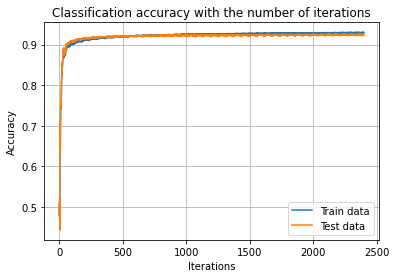

In [24]:
plt.title('Classification accuracy with the number of iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(score_train, label='Train data')
plt.plot(score_test, label='Test data')
plt.legend()
plt.grid()
plt.savefig('SLP_1.svg')

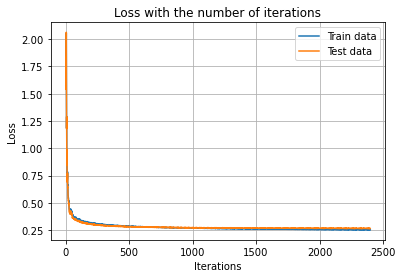

In [25]:
plt.title('Loss with the number of iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(loss_train, label='Train data')
plt.plot(loss_test, label='Test data')
plt.legend()
plt.grid()
plt.savefig('SLP_2.svg')